In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [2]:
stem_phase = "/home/doconnor/nucleusData/RG_IncuCyte_HT1080_Images/PhaseImages/"
stem_label = "/home/doconnor/nucleusData/RG_IncuCyte_HT1080_Images/RedMasks/"
stem_red = "/home/doconnor/nucleusData/RG_IncuCyte_HT1080_Images/RedImages/"

from os import listdir
from os.path import isfile, join
onlyFiles = [f for f in listdir(stem_phase) if isfile(join(stem_phase, f))]

In [3]:
def chopUpImage(img,labels,redImg,numRows,numCols):
    
    numRowsBigImg, numColsBigImg = img.shape
    numTilesX = math.floor(numColsBigImg/numCols)
    numTilesY = math.floor(numRowsBigImg/numRows)
    numTiles = numTilesX*numTilesY
    
    x = np.zeros((numTiles,numRows,numCols))
    y = np.zeros(x.shape)
    z = np.zeros(x.shape)
    
    idx = 0
    
    for j in range(numTilesX):
        for i in range(numTilesY):
            
            subImg = img[numRows*i:numRows*(i+1),numCols*j:numCols*(j+1)]
            subLabels = labels[numRows*i:numRows*(i+1),numCols*j:numCols*(j+1)]
            red = redImg[numRows*i:numRows*(i+1),numCols*j:numCols*(j+1)]
            x[idx,:,:] = subImg
            y[idx,:,:] = subLabels
            z[idx,:,:] = red
            
            idx += 1
            
    return (x,y,z)

In [4]:
imgNames = os.listdir(stem_phase)
labelImgNames = os.listdir(stem_label)

numImages = 200
numRows = 252
numCols = 252

numRowsBigImg = 944
numColsBigImg = 1280
numTilesX = math.floor(numColsBigImg/numCols)
numTilesY = math.floor(numRowsBigImg/numRows)
numTiles = numTilesX*numTilesY


X_train = np.zeros((numImages*numTiles,1,numRows,numCols))
Y_train = np.zeros(X_train.shape)
red_train = np.zeros(X_train.shape)


for i in range(numImages):
    
    print(imgNames[i])
    if imgNames[i][0] == '.':
        imgName = imgNames[i][2:]
    else:
        imgName = imgNames[i]
        
    labelName = imgName.replace('Phase','Red-Mask')
    redName = imgName.replace('Phase','Red')
        
    fname_img = stem_phase + imgName
    fname_label = stem_label + labelName
    fname_red = stem_red + redName
    
    img = plt.imread(fname_img)
    labels = plt.imread(fname_label)
    redImg = plt.imread(fname_red)
    
    img = img[:,:,0]
    labels = labels[:,:,0]
    redImg = redImg[:,:,0]
    
    subImgs, subLabels, subRed = chopUpImage(img,labels,redImg,numRows,numCols)
 
    X_train[numTiles*i:numTiles*(i+1),0,:,:] = subImgs
    Y_train[numTiles*i:numTiles*(i+1),0,:,:] = subLabels
    red_train[numTiles*i:numTiles*(i+1),0,:,:] = subRed
    
    
X_train = X_train/255.0
Y_train = Y_train/255.0

Y_train = Y_train[:,:,92:-92,92:-92]

X_train = np.float32(X_train)
Y_train = np.float32(Y_train)

HT1080_Phase_B11_1_02d15h00m.tif
HT1080_Phase_C4_1_00d09h00m.tif
HT1080_Phase_C8_1_01d21h00m.tif
HT1080_Phase_B9_1_03d15h00m.tif
HT1080_Phase_D2_1_00d15h00m.tif
HT1080_Phase_A4_1_03d18h00m.tif
HT1080_Phase_A11_1_04d15h00m.tif
HT1080_Phase_D1_1_01d09h00m.tif
HT1080_Phase_B10_1_02d15h00m.tif
HT1080_Phase_B1_1_01d00h00m.tif
HT1080_Phase_A8_1_01d15h00m.tif
HT1080_Phase_C2_1_04d06h00m.tif
HT1080_Phase_D6_1_03d06h00m.tif
HT1080_Phase_D6_1_01d15h00m.tif
HT1080_Phase_C7_1_01d03h00m.tif
HT1080_Phase_A3_1_00d21h00m.tif
HT1080_Phase_A6_1_03d09h00m.tif
HT1080_Phase_C3_1_01d18h00m.tif
HT1080_Phase_A9_1_00d09h00m.tif
HT1080_Phase_D1_1_03d12h00m.tif
HT1080_Phase_A8_1_01d18h00m.tif
HT1080_Phase_B4_1_01d06h00m.tif
HT1080_Phase_C8_1_01d12h00m.tif
HT1080_Phase_B3_1_04d18h00m.tif
HT1080_Phase_B7_1_00d18h00m.tif
HT1080_Phase_D5_1_01d18h00m.tif
HT1080_Phase_B7_1_02d06h00m.tif
HT1080_Phase_A7_1_01d18h00m.tif
HT1080_Phase_B4_1_00d06h00m.tif
HT1080_Phase_B11_1_03d18h00m.tif
HT1080_Phase_A5_1_02d21h00m.tif
HT10

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

In [6]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)


In [7]:
type(Y_train)

torch.Tensor

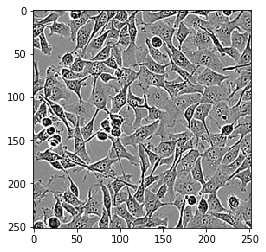

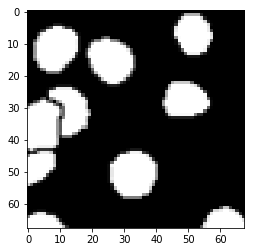

In [8]:
idx = 600
img = X_train[idx,0,:,:]
label = Y_train[idx,0,:,:]
plt.imshow(img, cmap = 'gray')
plt.figure()
plt.imshow(label,cmap = 'gray')


In [9]:
train_dataset = torch.utils.data.TensorDataset(X_train,Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val,Y_val)

In [10]:
N_train = len(train_dataset)
N_val = len(val_dataset)
print(N_train)
print(N_val)

2400
600


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=4)

In [12]:
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv1 = nn.Conv2d(1,64,3)
        self.conv2 = nn.Conv2d(64,64,3)
        
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv4 = nn.Conv2d(128,128,3)
        
        self.conv5 = nn.Conv2d(128,256,3)
        self.conv6 = nn.Conv2d(256,256,3)
        
        self.conv7 = nn.Conv2d(256,512,3)
        self.conv8 = nn.Conv2d(512,512,3)
        
        self.conv9 = nn.Conv2d(512,1024,3)
        self.conv10 = nn.Conv2d(1024,1024,3)
        
        self.upconv1 = nn.ConvTranspose2d(1024,512,2, stride = 2)
        self.conv11 = nn.Conv2d(1024,512,3)
        self.conv12 = nn.Conv2d(512,512,3)
        
        self.upconv2 = nn.ConvTranspose2d(512,256,2,stride = 2)
        self.conv13 = nn.Conv2d(512,256,3)
        self.conv14 = nn.Conv2d(256,256,3)
        
        self.upconv3 = nn.ConvTranspose2d(256,128,2,stride = 2)
        self.conv15 = nn.Conv2d(256,128,3)
        self.conv16 = nn.Conv2d(128,128,3)
        
        self.upconv4 = nn.ConvTranspose2d(128,64,2,stride = 2)
        self.conv17 = nn.Conv2d(128,64,3)
        self.conv18 = nn.Conv2d(64,64,3)
        
        self.conv19 = nn.Conv2d(64,1,1)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        keep1 = F.relu(self.conv2(x))
        
        x = self.pool(keep1)
        x = F.relu(self.conv3(x))
        keep2 = F.relu(self.conv4(x))
        
        x = self.pool(keep2)
        x = F.relu(self.conv5(x))
        keep3 = F.relu(self.conv6(x))
        
        x = self.pool(keep3)
        x = F.relu(self.conv7(x))
        keep4 = F.relu(self.conv8(x))
        
        x = self.pool(keep4)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = self.upconv1(x)
        keep4_cropped = keep4[:,:,4:-4,4:-4]
        x = torch.cat((keep4_cropped,x), dim = 1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = self.upconv2(x)
        keep3_cropped = keep3[:,:,16:-16,16:-16]
        x = torch.cat((keep3_cropped,x), dim = 1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = self.upconv3(x)
        keep2_cropped = keep2[:,:,40:-40,40:-40]
        x = torch.cat((keep2_cropped,x), dim = 1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = self.upconv4(x)
        keep1_cropped = keep1[:,:,88:-88,88:-88]
        x = torch.cat((keep1_cropped,x), dim = 1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv19(x)
        
        return x

In [13]:
device = torch.cuda.current_device()


In [14]:
model = unet()
model = model.to(device)

lossFun = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) # 200 iterations, not bad, still improving
optimizer = optim.RMSprop(model.parameters(), lr = 0.0001)

In [15]:
batch = torch.rand(4,1,252,252)
batch = batch.to(device)

check = model(batch)
print(torch.max(batch))
labels = torch.rand(4,1,68,68)
labels = labels.to(device)
L = lossFun(check,labels)
print(L)


tensor(1.0000, device='cuda:0')
tensor(0.6935, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [16]:
numEpochs = 16

trainLosses = []
valLosses = []

for ep in range(numEpochs):
    
    runningLoss = 0.0
    
    idx = 0
    
    for X_batch, Y_batch in train_dataloader:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        prediction = model(X_batch)
        L_batch = lossFun(prediction, Y_batch)
        
        model.zero_grad()
        
        L_batch.backward()
        optimizer.step()
        
        runningLoss += L_batch*X_batch.shape[0]
        

        idx += 1
        if idx % 100 == 0:
            
            print("Epoch: ", ep, " idx: ", idx, " cost: ", runningLoss/(4*idx))
            
    val_loss = 0.0
    for X_batch, Y_batch in val_dataloader:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
        
            predictions = model(X_batch)
            
            L_batch = lossFun(predictions, Y_batch)
            val_loss += L_batch*X_batch.shape[0]
        
        

    trainLosses.append(runningLoss/N_train)
    valLosses.append(val_loss/N_val)
    print('After epoch ', ep, ' runningLoss/N_train is: ', runningLoss/N_train, ' val_loss/N_val is: ', val_loss/N_val)

Epoch:  0  idx:  100  cost:  tensor(0.3603, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  0  idx:  200  cost:  tensor(0.2857, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  0  idx:  300  cost:  tensor(0.2603, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  0  idx:  400  cost:  tensor(0.2520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  0  idx:  500  cost:  tensor(0.2394, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  0  idx:  600  cost:  tensor(0.2341, device='cuda:0', grad_fn=<DivBackward0>)
After epoch  0  runningLoss/N_train is:  tensor(0.2341, device='cuda:0', grad_fn=<DivBackward0>)  val_loss/N_val is:  tensor(0.2030, device='cuda:0')
Epoch:  1  idx:  100  cost:  tensor(0.1797, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1  idx:  200  cost:  tensor(0.1827, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1  idx:  300  cost:  tensor(0.1889, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1  idx:  400  cost:  tensor(0.1852, device='cuda:0', grad_fn=<DivBackward0>)


Epoch:  12  idx:  500  cost:  tensor(0.0927, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  12  idx:  600  cost:  tensor(0.0934, device='cuda:0', grad_fn=<DivBackward0>)
After epoch  12  runningLoss/N_train is:  tensor(0.0934, device='cuda:0', grad_fn=<DivBackward0>)  val_loss/N_val is:  tensor(0.1001, device='cuda:0')
Epoch:  13  idx:  100  cost:  tensor(0.0967, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13  idx:  200  cost:  tensor(0.0939, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13  idx:  300  cost:  tensor(0.0924, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13  idx:  400  cost:  tensor(0.0900, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13  idx:  500  cost:  tensor(0.0913, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13  idx:  600  cost:  tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)
After epoch  13  runningLoss/N_train is:  tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)  val_loss/N_val is:  tensor(0.0982, device='cuda:0')
Epoch:  14

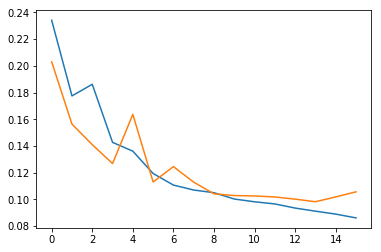

In [17]:
plt.plot(trainLosses); plt.plot(valLosses)

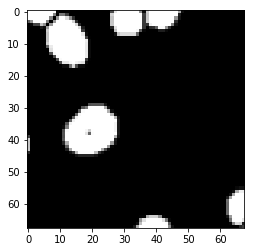

In [34]:
X_batch, Y_batch = next(iter(val_dataloader))
img = X_batch[0,0,:,:]
mask = Y_batch[0,0,:,:]
plt.imshow(mask, cmap = 'gray')


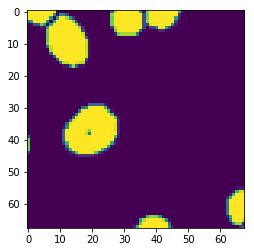

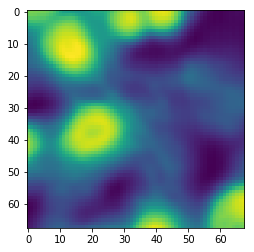

In [35]:
X_batch = X_batch.to(device)
Y_batch = Y_batch.to(device)
prediction = model(X_batch)

plt.figure()
plt.imshow(Y_batch.cpu()[0,0,:,:])
plt.figure()
plt.imshow(prediction.cpu().detach().numpy()[0,0,:,:])
